In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import shap
import pickle

%matplotlib inline
# Suppress warndings 
import warnings

warnings.filterwarnings('ignore')
print("Environment setup successful!")

Environment setup successful!


### **Read Datasets**

In [2]:
# Set up Data path
data_path  = '../data/raw/home-credit-default-risk/'

In [3]:
app_train = pd.read_csv(data_path+'application_train.csv')
pre_appl = pd.read_csv(data_path+'previous_application.csv')
pos_cash = pd.read_csv(data_path+'POS_CASH_balance.csv')
install_pay = pd.read_csv(data_path+'installments_payments.csv')
credit_card = pd.read_csv(data_path+'credit_card_balance.csv')
bureau = pd.read_csv(data_path+'bureau.csv')
bur_bal = pd.read_csv(data_path+'bureau_balance.csv')
print("Downloaded Datasets successful!")

Downloaded Datasets successful!


In [4]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## **Part 1: Overview Data Quality  & Exploratory Data Analysis** 

### **1.1 Data Quality Check**
- **Missing Value:** identify missing values among datasets to assess the risk of insufficinet of datasets
- **Data Types:** identify data types  among datasets to assess the nature of datasets for data tranformation

In [5]:
def calculate_missing_values_percentage(df):
    """
    Calculate the percentage of missing value for each columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    
    Returns:
    pd.DataFrame: A dataframe containing the percentage of missing values for each column by sorting in descending order.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean() * 100
    
    # Filter out columns that have no missing values
    missing_percentage = missing_percentage[missing_percentage > 0]
    
    # Create a new DataFrame with the results
    missing_percentage_df = pd.DataFrame(missing_percentage, columns=['Missing Percentage'])
    
    # Sort the DataFrame in descending order
    missing_percentage_df = missing_percentage_df.sort_values(by='Missing Percentage', ascending=False)
    
    return missing_percentage_df

In [6]:
missing_app_train = calculate_missing_values_percentage(app_train)
missing_pre_appl = calculate_missing_values_percentage(pre_appl)
missing_pos_cash = calculate_missing_values_percentage(pos_cash)
missing_install = calculate_missing_values_percentage(install_pay)
missing_credit_card = calculate_missing_values_percentage(credit_card)
missing_bureau = calculate_missing_values_percentage(bureau)
missing_bur_bal = calculate_missing_values_percentage(bur_bal)

In [7]:
# Identify the columns with more than 50% missing values
print(missing_app_train[missing_app_train['Missing Percentage']>=50].head(20))

                          Missing Percentage
COMMONAREA_MEDI                    69.872297
COMMONAREA_AVG                     69.872297
COMMONAREA_MODE                    69.872297
NONLIVINGAPARTMENTS_MEDI           69.432963
NONLIVINGAPARTMENTS_MODE           69.432963
NONLIVINGAPARTMENTS_AVG            69.432963
FONDKAPREMONT_MODE                 68.386172
LIVINGAPARTMENTS_MODE              68.354953
LIVINGAPARTMENTS_MEDI              68.354953
LIVINGAPARTMENTS_AVG               68.354953
FLOORSMIN_MODE                     67.848630
FLOORSMIN_MEDI                     67.848630
FLOORSMIN_AVG                      67.848630
YEARS_BUILD_MODE                   66.497784
YEARS_BUILD_MEDI                   66.497784
YEARS_BUILD_AVG                    66.497784
OWN_CAR_AGE                        65.990810
LANDAREA_AVG                       59.376738
LANDAREA_MEDI                      59.376738
LANDAREA_MODE                      59.376738


In [8]:
print(missing_pre_appl[missing_pre_appl['Missing Percentage']>=50])

                          Missing Percentage
RATE_INTEREST_PRIMARY              99.643698
RATE_INTEREST_PRIVILEGED           99.643698
AMT_DOWN_PAYMENT                   53.636480
RATE_DOWN_PAYMENT                  53.636480


In [9]:
print(missing_pos_cash[missing_pos_cash['Missing Percentage']>=50])

Empty DataFrame
Columns: [Missing Percentage]
Index: []


In [10]:
print(missing_install[missing_install['Missing Percentage']>=50])

Empty DataFrame
Columns: [Missing Percentage]
Index: []


In [11]:
print(missing_credit_card[missing_credit_card['Missing Percentage']>=50])

Empty DataFrame
Columns: [Missing Percentage]
Index: []


In [12]:
print(missing_bureau[missing_bureau['Missing Percentage']>=50])

                        Missing Percentage
AMT_ANNUITY                      71.473490
AMT_CREDIT_MAX_OVERDUE           65.513264


In [13]:
print(missing_bur_bal[missing_bur_bal['Missing Percentage']>=50])

Empty DataFrame
Columns: [Missing Percentage]
Index: []


- **Explore Dtype:** explore the data types by value count the dtypes and assess the object type for treatment in the future for encoder

In [14]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [15]:
pre_appl.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

In [16]:
pos_cash.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

In [17]:
install_pay.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [18]:
credit_card.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [19]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

In [20]:
bur_bal.dtypes.value_counts()

int64     2
object    1
dtype: int64

#### **1.1 Data Quality Check Finding**

##### **Missing Values**
- The `app_train` dataset contains several columns with a high percentage of missing values, some exceeding **60%**.
- The `pre_appl` dataset also has columns with substantial missing values, with some exceeding **50%**.
- The `pos_cash`, `install_pay`, `credit_card`, and `bur_bal` datasets have relatively fewer missing values, with no columns exceeding **50%** missing data.
- The `bureau` dataset has some columns with over **60%** missing values.

##### **Data Types**
The datasets contain a mix of **integer (`int64`), float (`float64`), and categorical (`object`)** data types:

| Dataset       | `int64` Columns | `float64` Columns | `object` Columns |
|--------------|----------------|-------------------|-----------------|
| `app_train`  | 41             | 65                | 16              |
| `pre_appl`   | 16             | 13                | 16              |
| `pos_cash`   | 3              | 1                 | 1               |
| `install_pay`| 4              | 2                 | 0               |
| `credit_card`| 5              | 10                | 1               |
| `bureau`     | 7              | 3                 | 1               |
| `bur_bal`    | 2              | 0                 | 1               |

##### **Summary**
- **Data Sufficiency Risk:** `app_train`, `pre_appl`, and `bureau` datasets require careful handling due to high missing values.
- **Data Transformation Needs:** Various datasets have mixed data types (`int64`, `float64`, `object`), necessitating preprocessing steps like type conversion and encoding.
- **Next Steps:** Imputation strategies and feature engineering are required to handle missing values and ensure data usability such as encoder label one-hot code or encode categoricals

### **1.2 Exploratory Data Analysis (EDA)**

Text(0, 0.5, 'Count')

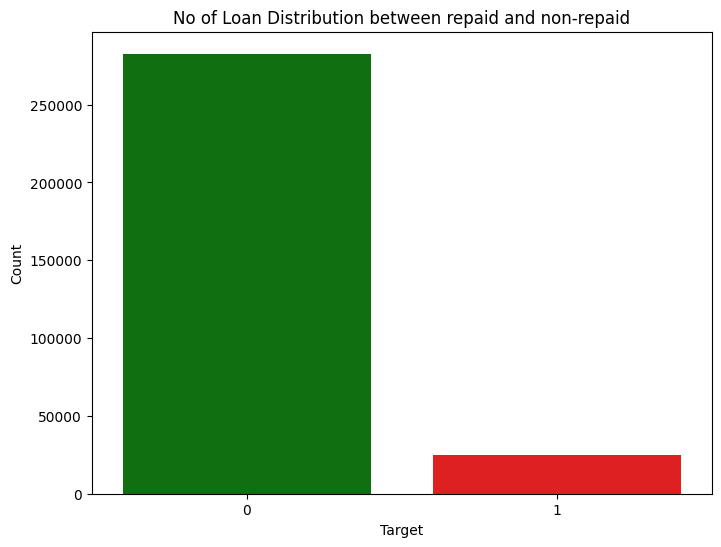

In [21]:
# Plot the target distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='TARGET', data=app_train, palette={0: 'green', 1: 'red'})
plt.title('No of Loan Distribution between repaid and non-repaid')
plt.xlabel('Target')
plt.ylabel('Count')

#### **Observations Target 0 vs 1**  
The bar chart shows a significant class imbalance in loan repayment status. The majority of loans were fully repaid (`Target = 0`), while a much smaller proportion defaulted (`Target = 1`) **approximatly 10 % of fully repaid**. This imbalance suggests that most applicants successfully meet their repayment obligations, but a minority face financial difficulties leading to default.  

#### **1.2.1 EDA on numerical features using KDE to see the feature well separate or not** 

In [22]:
def plot_distribution(data, target_column, x_axis, ax, title, xlabel, ylabel):
    """
    Plots the KDE for the specified x_axis for both Non-Defaulters (0) and Defaulters (1).

    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    target_column (str): The name of the target column.
    x_axis (str): The name of the x-axis column.
    ax (matplotlib.axes.Axes): The axes on which to plot the KDE.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    """
    sns.kdeplot(data=data[data[target_column] == 0], x=x_axis, label='Non-Defaulters (0)', fill=True, color='green', ax=ax)
    sns.kdeplot(data=data[data[target_column] == 1], x=x_axis, label='Defaulters (1)', fill=True, color='red', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

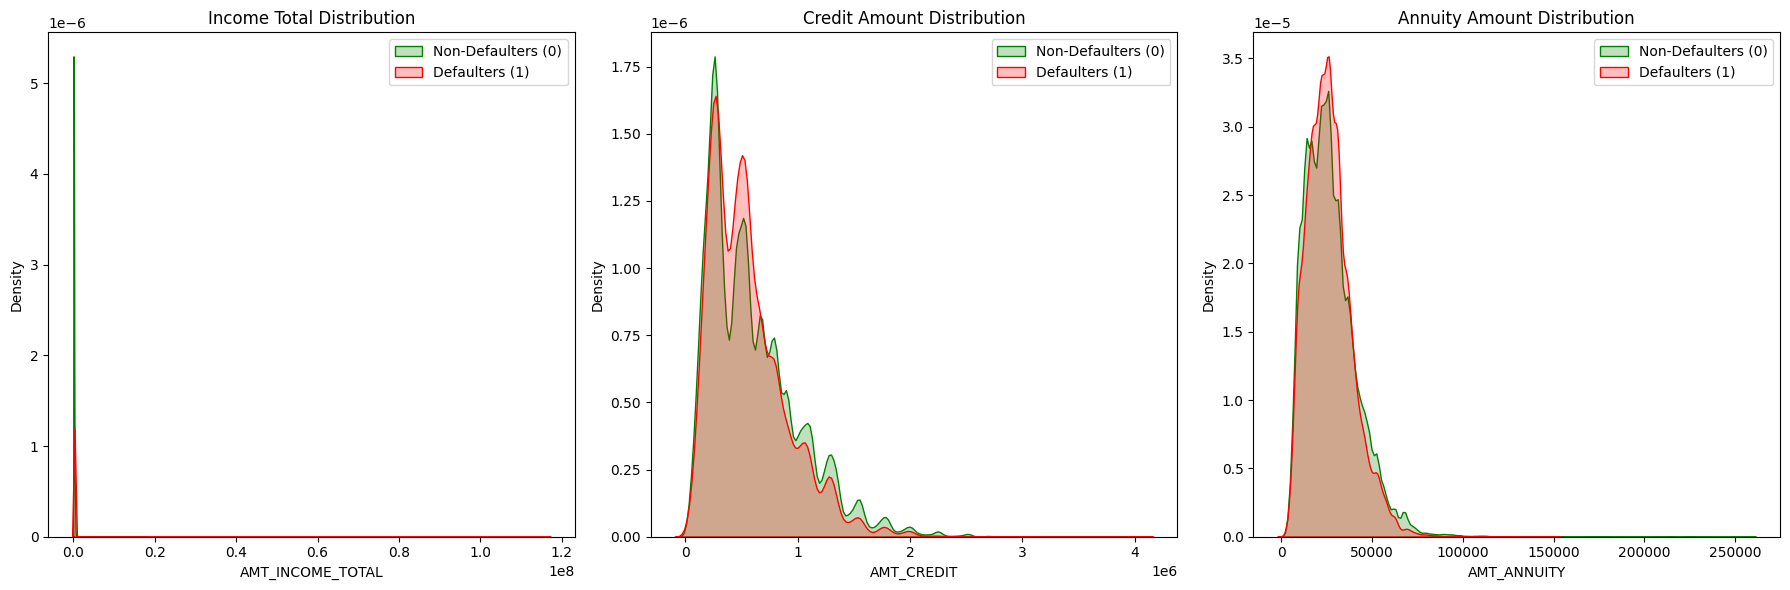

In [23]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for AMT_INCOME_TOTAL
plot_distribution(app_train, 'TARGET', 'AMT_INCOME_TOTAL', axes[0], 'Income Total Distribution', 'AMT_INCOME_TOTAL', 'Density')

# Plot for AMT_CREDIT
plot_distribution(app_train, 'TARGET', 'AMT_CREDIT', axes[1], 'Credit Amount Distribution', 'AMT_CREDIT', 'Density')

# Plot for AMT_ANNUITY
plot_distribution(app_train, 'TARGET', 'AMT_ANNUITY', axes[2], 'Annuity Amount Distribution', 'AMT_ANNUITY', 'Density')

plt.tight_layout()
plt.show()

#### **Observations**  
The kde charts shows those income total, Credit Amount, and Annuity amount features are mostly overlap between both charts (`Target = 0`) and (`Target = 1`). These infer that thoes features may not be as effective for classification

#### **Inspect Anomalies in Total Income**  
- **Outlier Detection:** The chart reveals an extreme outlier at **117,000,000**, causing a significant right skew. To assess its impact, we need to analyze the percentage of affected records in relation to the target variable.  

In [24]:
#   Extract the records to see the percentage 
anomaly = app_train[app_train['AMT_INCOME_TOTAL'] == 117000000]
non_anomaly = app_train[app_train['AMT_INCOME_TOTAL'] != 117000000]
print(f"Percentage of anomalies of the loan: {anomaly['TARGET'].mean() * 100:.2f}%")
print(f"Percentage of non-anomalies of the loan: {non_anomaly['TARGET'].mean() * 100:.2f}%")

Percentage of anomalies of the loan: 100.00%
Percentage of non-anomalies of the loan: 8.07%


#### **Observations**
The percentage of anomalies for income (`117,000,000`) is 100% that indicate that all records with unusal high income is a loan default (`Target = 1`). So, this amount is likely an error or outlier

In [25]:
# Flag the records with anomalous DAYS_EMPLOYED values
app_train['AMT_INCOME_TOTAL_ANOM'] = app_train['AMT_INCOME_TOTAL'] == 117000000

# Replace anomalous values in DAYS_EMPLOYED with NaN
app_train['AMT_INCOME_TOTAL'].replace(117000000, np.nan, inplace=True)

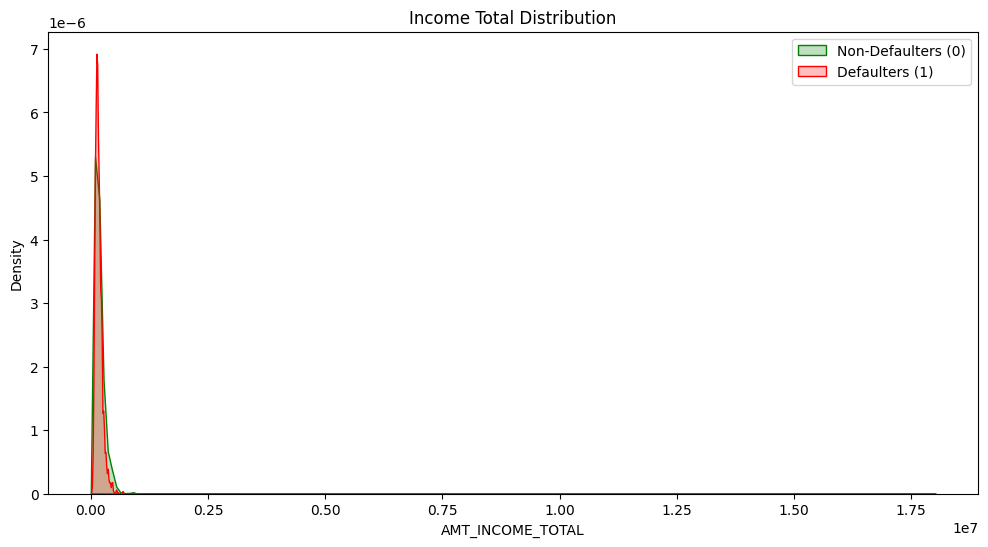

In [26]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the KDE for AMT_INCOME_TOTAL using the plot_distribution function
plot_distribution(app_train, 'TARGET', 'AMT_INCOME_TOTAL', ax, 'Income Total Distribution', 'AMT_INCOME_TOTAL', 'Density')

plt.show()

#### **Observations**
The kde charts shows those cleaned income total amount features are mostly overlap between both charts (`Target = 0`) and (`Target = 1`). These infer that thoes features may not be as effective for classification

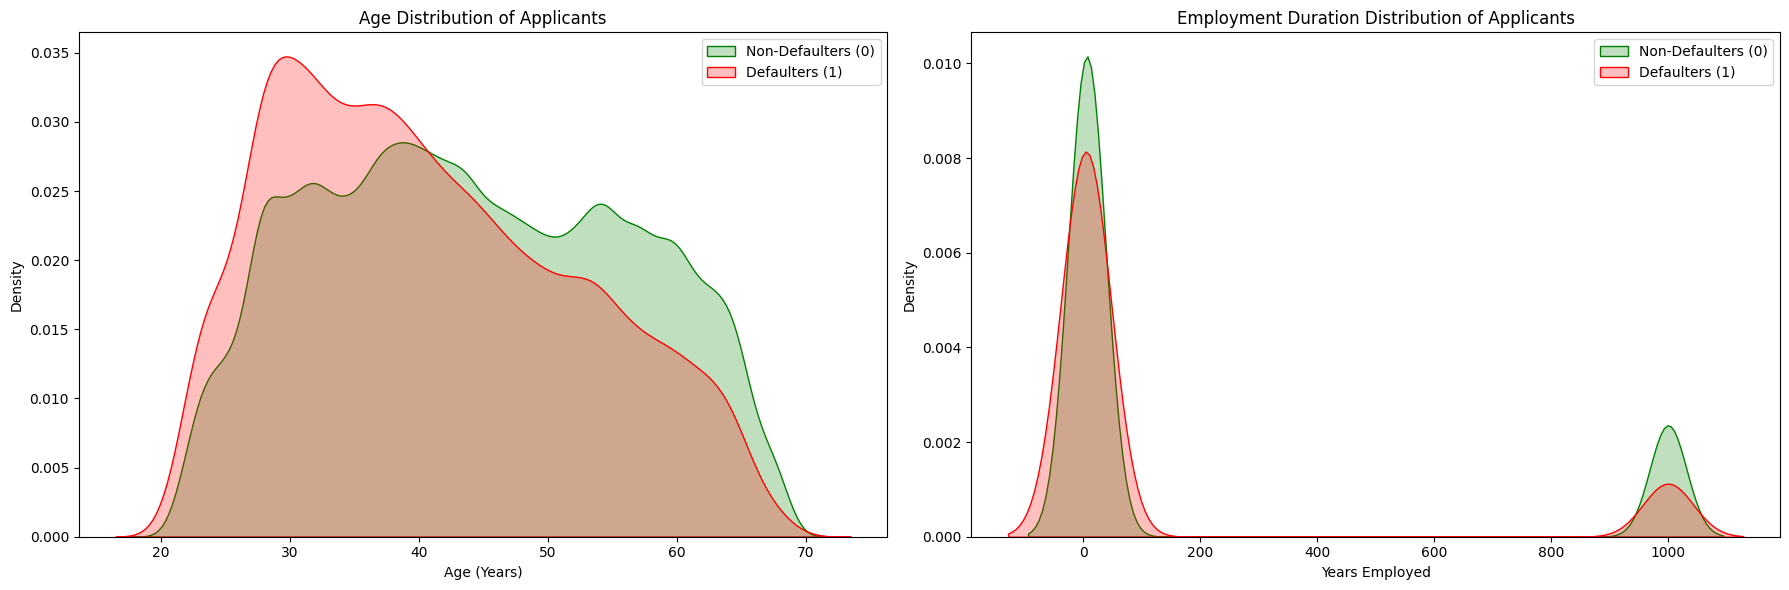

In [27]:
# Transform DAYS_BIRTH and DAYS_EMPLOYED into years
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / -365
app_train['YEARS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'] / -365)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the KDE for YEARS_BIRTH using the plot_distribution function
plot_distribution(app_train, 'TARGET', 'YEARS_BIRTH', axes[0], 'Age Distribution of Applicants', 'Age (Years)', 'Density')

# Plot the KDE for YEARS_EMPLOYED using the plot_distribution function
plot_distribution(app_train, 'TARGET', 'YEARS_EMPLOYED', axes[1], 'Employment Duration Distribution of Applicants', 'Years Employed', 'Density')

plt.tight_layout()
plt.show()

#### **Observations**  
The kde charts shows those Age and Employment features are mostly overlap between both charts (`Target = 0`) and (`Target = 1`). These infer that thoes features may not be as effective for classification. Furthermore we found anomaly year of employement over 1,000 years.

In [28]:
# Extract the records to see the percentage 
anomaly = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anomaly = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print(f"Percentage of anomalies of the loan: {anomaly['TARGET'].mean() * 100:.2f}%")
print(f"Percentage of non-anomalies in the dataset: {non_anomaly['TARGET'].mean() * 100:.2f}%")

Percentage of anomalies of the loan: 5.40%
Percentage of non-anomalies in the dataset: 8.66%


#### **Observations**
The percentage of anomalies for day_employed (`365,243 days`) is 5.4% but this information seems to be an error since it's impossible for a person to employ over 1,000 years

Fill anomalies to be na

In [29]:
# Flag the records with anomalous DAYS_EMPLOYED values
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

# Replace anomalous values in DAYS_EMPLOYED with NaN
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
# Note why we are replacing the values with NaN

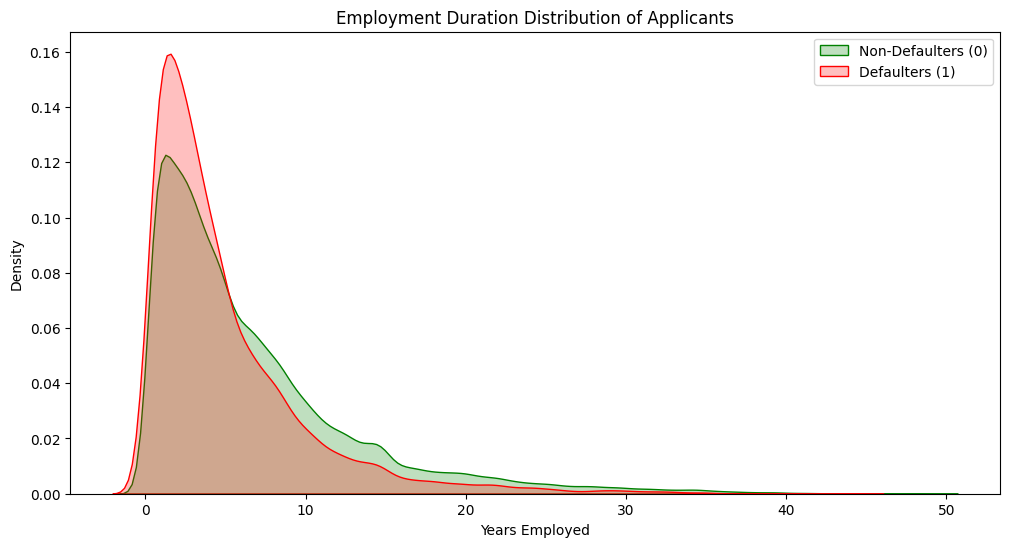

In [30]:
# Transform DAYS_EMPLOYED into years
app_train['YEARS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'] / 365)

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the KDE for YEARS_EMPLOYED using the plot_distribution function
plot_distribution(app_train, 'TARGET', 'YEARS_EMPLOYED', ax, 'Employment Duration Distribution of Applicants', 'Years Employed', 'Density')

plt.show()

#### **Observations**
The kde charts shows those cleaned year employed features are mostly overlap between both charts (`Target = 0`) and (`Target = 1`). These infers that thoes features may not be as effective for classification

#### **1.2.2 EDA on Categorical features using histrogram to see the feature well separate or not**

In [31]:
def plot_histogram(data, y_axis, target_column, ax, title, xlabel, ylabel):
    """
    Plots a histogram for the specified y_axis with hue based on the target column.

    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    y_axis (str): The name of the y-axis column.
    target_column (str): The name of the target column.
    ax (matplotlib.axes.Axes): The axes on which to plot the histogram.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    """
    sns.histplot(data=data, y=y_axis, hue=target_column, multiple='stack', ax=ax, palette={0: 'green', 1: 'red'})
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

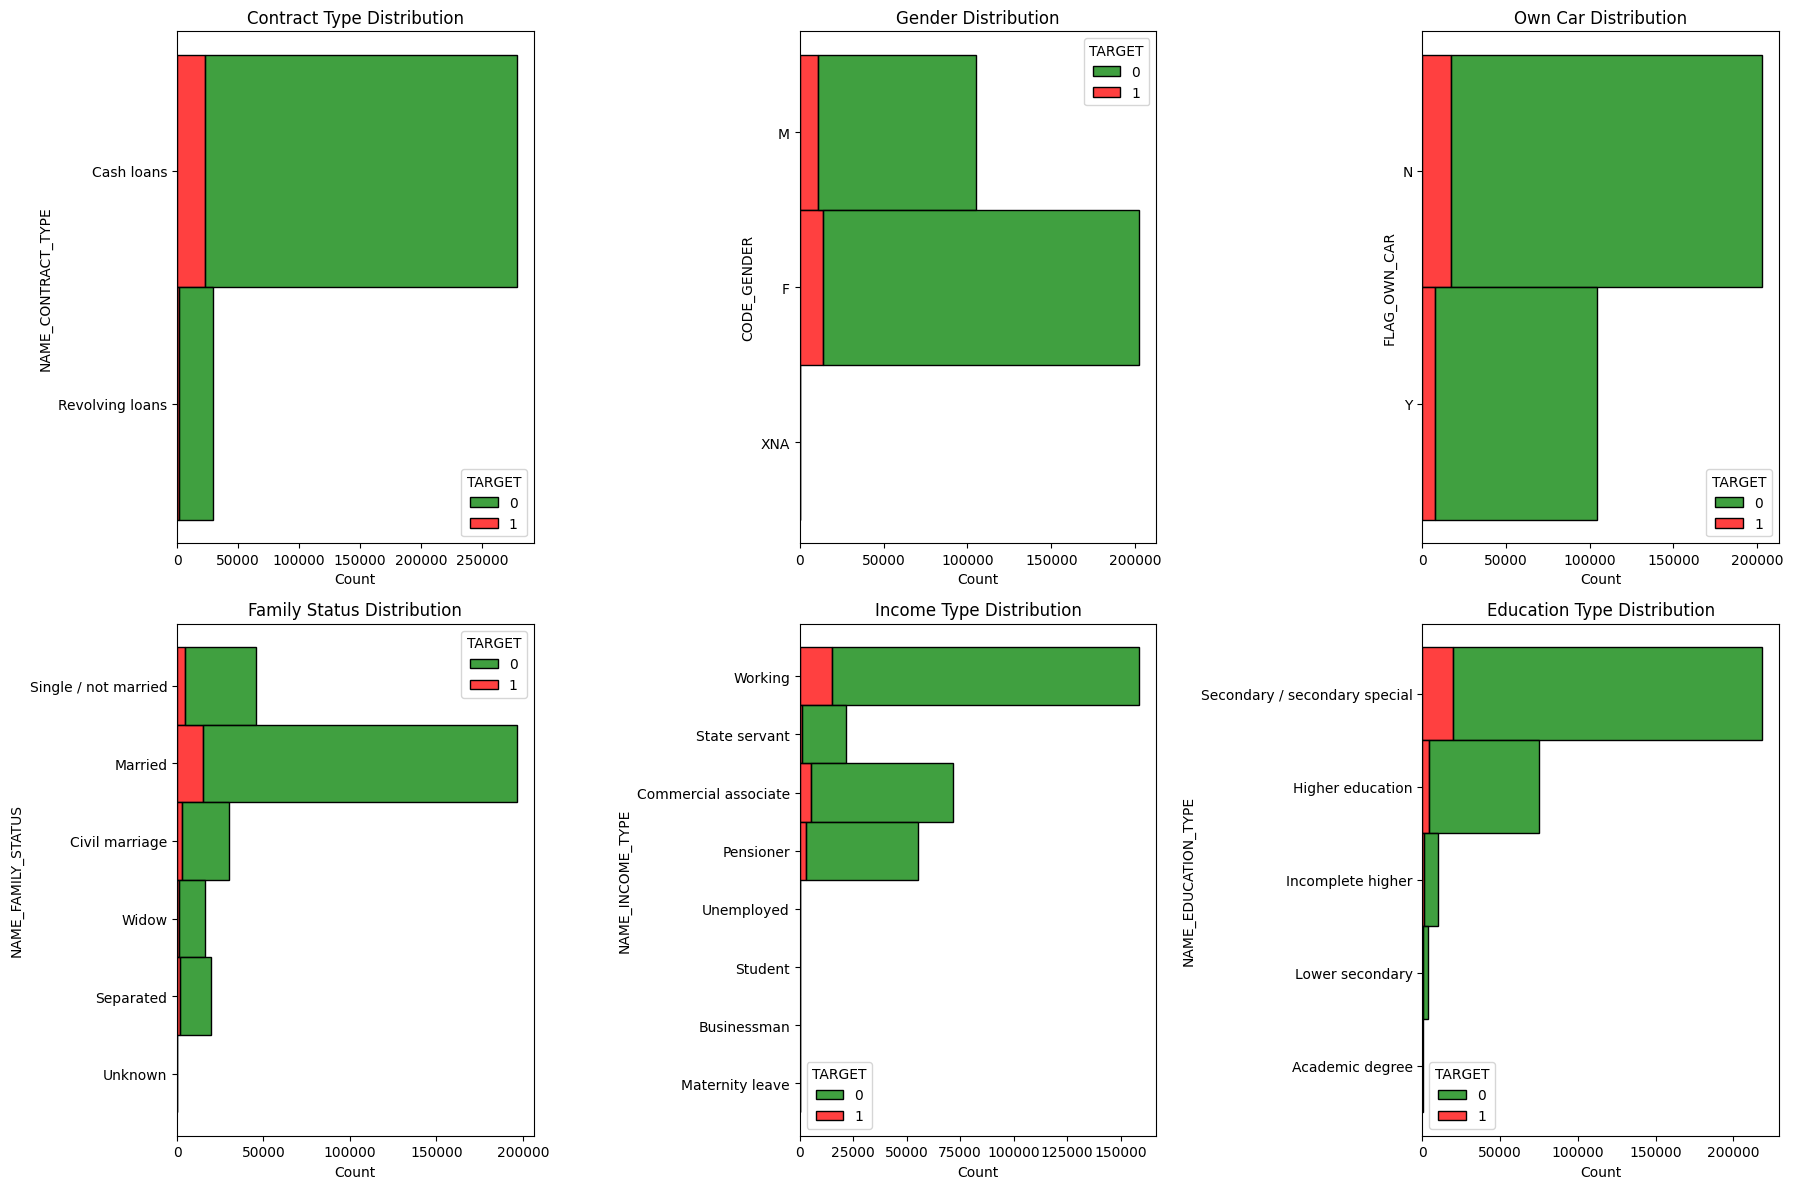

In [32]:
# Create a figure with six subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot the histograms using the plot_histogram function
plot_histogram(app_train, 'NAME_CONTRACT_TYPE', 'TARGET', axes[0, 0], 'Contract Type Distribution', 'Count', 'NAME_CONTRACT_TYPE')
plot_histogram(app_train, 'CODE_GENDER', 'TARGET', axes[0, 1], 'Gender Distribution', 'Count', 'CODE_GENDER')
plot_histogram(app_train, 'FLAG_OWN_CAR', 'TARGET', axes[0, 2], 'Own Car Distribution', 'Count', 'FLAG_OWN_CAR')
plot_histogram(app_train, 'NAME_FAMILY_STATUS', 'TARGET', axes[1, 0], 'Family Status Distribution', 'Count', 'NAME_FAMILY_STATUS')
plot_histogram(app_train, 'NAME_INCOME_TYPE', 'TARGET', axes[1, 1], 'Income Type Distribution', 'Count', 'NAME_INCOME_TYPE')
plot_histogram(app_train, 'NAME_EDUCATION_TYPE', 'TARGET', axes[1, 2], 'Education Type Distribution', 'Count', 'NAME_EDUCATION_TYPE')

plt.tight_layout()
plt.show()

#### **Summary of Findings**  

- **Contract Type:** Certain contract types may be more associated with loan defaults.  
- **Gender:** Identifying potential gender-based patterns in loan defaults.  
- **Car Ownership:** Evaluating whether owning a car impacts loan repayment behavior.  
- **Family Status:** Assessing if specific family statuses correlate with higher default rates.  
- **Income Type:** Exploring the relationship between income types and loan defaults.  
- **Education Level:** Determining if education levels influence loan repayment outcomes.  

#### **Observation**  
The histograms with stacked bars provide a clear visualization of categorical feature distributions and their relationship with loan defaults. These insights help identify key factors influencing loan repayment behavior, supporting further analysis and model development.  

#### **1.2.3 Domain Knowledge Features**  

- **Credit to Income Ratio (`credit_income_percent`)**: Measures the proportion of total credit amount relative to annual income. A higher ratio may indicate a higher debt burden, potentially increasing the risk of default.  

- **Annuity to Income Ratio (`annuity_income_percent`)**: Represents the fraction of annual annuity payments relative to total income. A high percentage suggests a significant financial commitment, which could affect a borrower's ability to meet loan obligations.  

- **Credit Term (`credit_term`)**: Calculates the approximate loan duration in years by dividing total credit amount by annuity payments. Longer loan terms may indicate lower monthly payments but could also increase overall financial risk if income stability is uncertain.  

These features provide valuable insights into a borrower's financial capacity and debt burden, helping assess creditworthiness and potential default risk.  

**Source:** [LightGBM with Simple Features - Kaggle](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993)  

In [33]:
# Copy App_train to new dataset
app_train_domain = app_train.copy()

# Create new columns
app_train_domain['credit_income_percent'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train_domain['annuity_income_percent'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train_domain['credit_term'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']


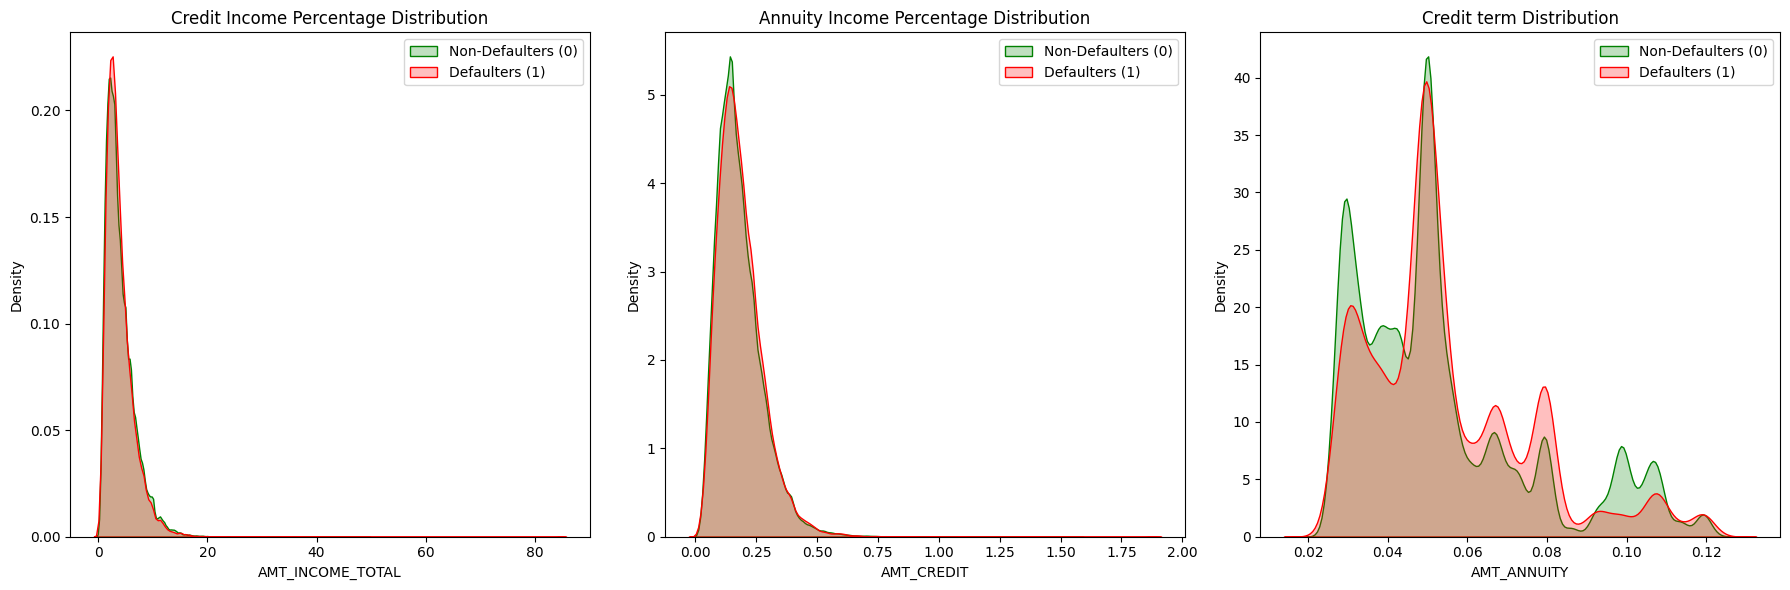

In [34]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for AMT_INCOME_TOTAL
plot_distribution(app_train_domain, 'TARGET', 'credit_income_percent', axes[0], 'Credit Income Percentage Distribution', 'AMT_INCOME_TOTAL', 'Density')

# Plot for AMT_CREDIT
plot_distribution(app_train_domain, 'TARGET', 'annuity_income_percent', axes[1], 'Annuity Income Percentage Distribution', 'AMT_CREDIT', 'Density')

# Plot for AMT_ANNUITY
plot_distribution(app_train_domain, 'TARGET', 'credit_term', axes[2], 'Credit term Distribution', 'AMT_ANNUITY', 'Density')

plt.tight_layout()
plt.show()

#### **Observations**  
The kde charts shows those Credit income percentage total, Annuity Income percentage, and Credit Term features are mostly overlap between both charts (`Target = 0`) and (`Target = 1`). These infer that thoes features may not be as effective for classification

#### **1.2.4 Find Correlation among features to the target**

In [35]:
# corr  = app_train.corr()['TARGET'].sort_values(ascending=False)
corr  = app_train_domain.corr()['TARGET'].sort_values(ascending=False)

In [36]:
print('Most Positive Correlations:\n', corr.head(10))
print('\nMost Negative Correlations:\n', corr.tail(10))

Most Positive Correlations:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
Name: TARGET, dtype: float64

Most Negative Correlations:
 AMT_GOODS_PRICE      -0.039645
FLOORSMAX_MODE       -0.043226
FLOORSMAX_MEDI       -0.043768
FLOORSMAX_AVG        -0.044003
DAYS_EMPLOYED_ANOM   -0.045987
YEARS_EMPLOYED       -0.074958
YEARS_BIRTH          -0.078239
EXT_SOURCE_1         -0.155317
EXT_SOURCE_2         -0.160472
EXT_SOURCE_3         -0.178919
Name: TARGET, dtype: float64


#### **Correlation Findings**  

##### **Top 3 Positive Correlations with Target**  
1. **DAYS_BIRTH (0.078)** – Older applicants tend to have a slightly higher likelihood of loan default.  
2. **DAYS_EMPLOYED (0.075)** – Longer employment duration is positively correlated with default risk, which may indicate instability in job history.  
3. **REGION_RATING_CLIENT_W_CITY (0.061)** – Clients from regions with lower ratings may have a higher tendency to default.  

##### **Top 3 Negative Correlations with Target**  
1. **EXT_SOURCE_3 (-0.179)** – A strong negative correlation suggests that higher external credit scores are associated with lower default risk.  
2. **EXT_SOURCE_2 (-0.160)** – Similar to EXT_SOURCE_3, this indicates that external credit scores are strong predictors of financial reliability.  
3. **EXT_SOURCE_1 (-0.155)** – External sources provide valuable insights into creditworthiness, with higher scores linked to lower default probabilities.  

These findings highlight that external credit scores are among the most significant indicators of loan default risk, whereas age and employment duration show moderate positive correlations. However top 3 both positive and negative are less than 0.2 which is weak correlated. 

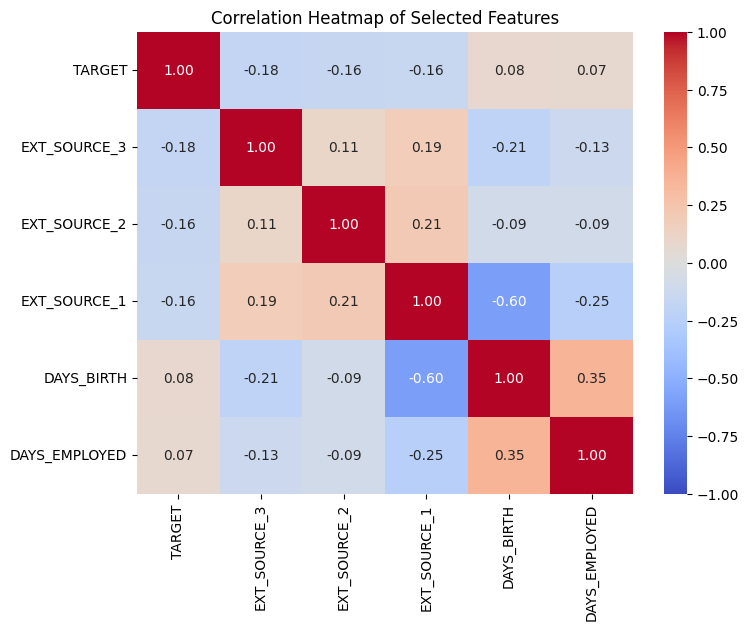

In [37]:
# Calculate the correlation matrix
corr_matrix = app_train.corr()

# Select the most negatively and positively correlated features
selected_features = ['TARGET','EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Filter the correlation matrix for the selected features
filtered_corr_matrix = corr_matrix.loc[selected_features, selected_features]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

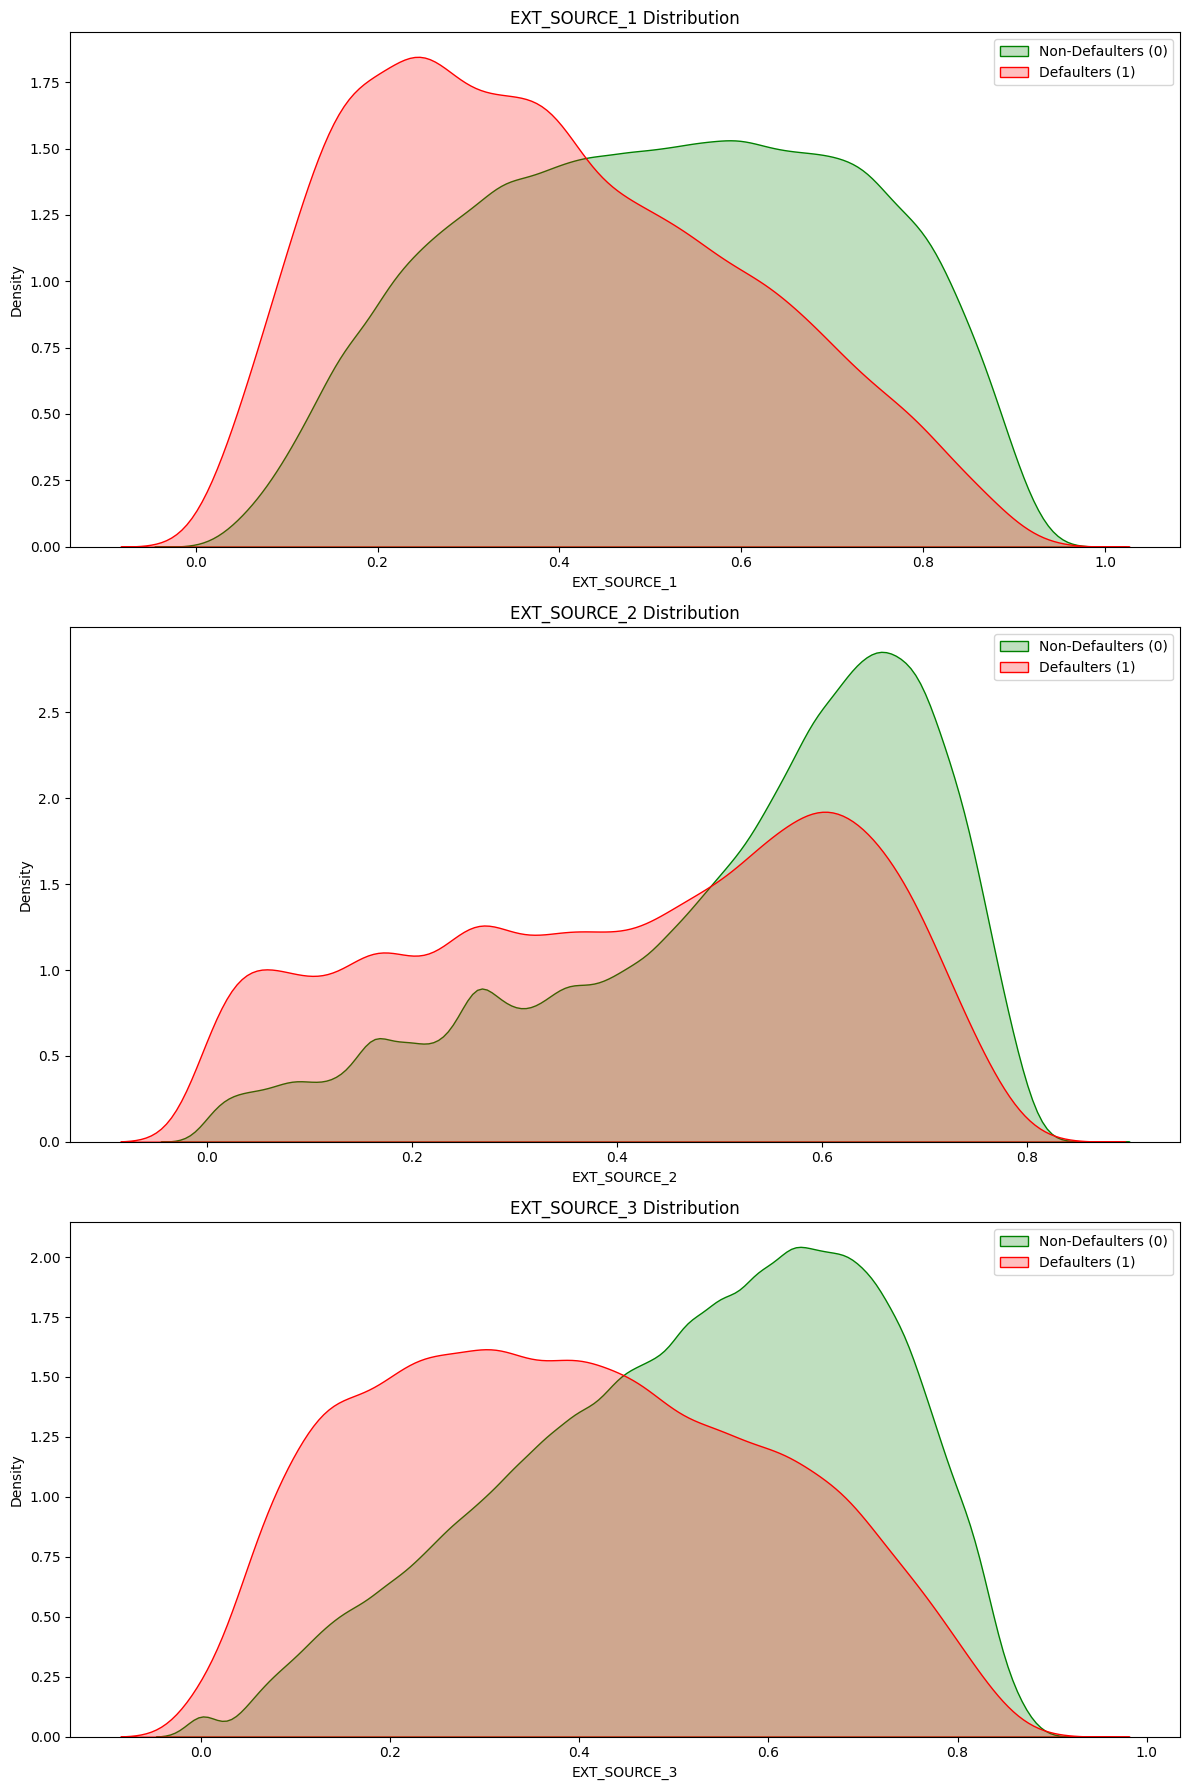

In [38]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# List of EXT_SOURCE features
ext_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Loop through each EXT_SOURCE feature and use the plot_distribution function
for i, source in enumerate(ext_sources):
    plot_distribution(app_train, 'TARGET', source, axes[i], f'{source} Distribution', source, 'Density')

plt.tight_layout()
plt.show()

#### **Observations**  
The kde charts shows those EXT_Source_1, EXT_Source_2, and EXT_Source_3 are less overlap between both charts (`Target = 0`) and (`Target = 1`). These EXT_source infer that thoes features may be as effective for classification which are related to top 3 negative correlation.

#### **1.2.5 Observations Others datasets**   

#### **1. bureau.csv**
- **Description:** Contains all client's previous credits provided by other financial institutions that were reported to the Credit Bureau. For every loan in our sample, there are as many rows as the number of credits the client had in the Credit Bureau before the application date.
#### **2. bureau_balance**
- **Description:** Contains monthly balances of previous credits in the Credit Bureau. This table has one row for each month of history of every previous credit reported to the Credit Bureau.
#### **3. POS_CASH_balance.csv**
- **Description:** Contains monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit.
#### **4. credit_card_balance.csv**
- **Description:** Contains monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit.
#### **5. previous_application.csv**
- **Description:** Contains all previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.
#### **6. installments_payments.csv**
- **Description:** Contains repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is one row for every payment that was made plus one row each for missed payment.

#### **Approach aggreation dataset**
During EDA process, the datasets have one-to-many relationships such as burea, pos_cash_balance, etc 
Hence, aggregation will helps handling one-to-many relationships and summarise the information to easier joining with app_train

In [39]:
def aggregate_data(df, drop_column, id_column):
    """
    Aggregates the data by the specified ID column, dropping the specified column,
    and calculating count, mean, max, min, and sum for all other columns.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to aggregate.
    drop_column (str): The column name to drop (e.g., 'SK_ID_BUREAU').
    id_column (str): The column name to group by (e.g., 'SK_ID_CURR').
    
    Returns:
    pd.DataFrame: The aggregated DataFrame.
    """
    # Drop the specified column
    if drop_column is not None:
        df = df.drop(columns=[drop_column])
    
    # Aggregate all columns with count, mean, max, min, and sum
    df_agg = df.groupby(id_column).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # Add a prefix to each column while ignoring id_column
    df_agg.columns = [f'{col[0]}_{col[1]}' if col[0] != id_column else col[0] for col in df_agg.columns]
       
    return df_agg

In [40]:
bur_bal_agg = aggregate_data(bur_bal, None, 'SK_ID_BUREAU')
bur_bal_agg.head()

,SK_ID_BUREAU,MONTHS_BALANCE_count,MONTHS_BALANCE_mean,MONTHS_BALANCE_max,MONTHS_BALANCE_min,MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [41]:
bureau = bureau.merge(bur_bal_agg, on='SK_ID_BUREAU', how='left')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_count,MONTHS_BALANCE_mean,MONTHS_BALANCE_max,MONTHS_BALANCE_min,MONTHS_BALANCE_sum
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
bureau_agg = aggregate_data(bureau, 'SK_ID_BUREAU','SK_ID_CURR')
bureau_agg.head()

,SK_ID_CURR,DAYS_CREDIT_count,DAYS_CREDIT_mean,DAYS_CREDIT_max,DAYS_CREDIT_min,DAYS_CREDIT_sum,CREDIT_DAY_OVERDUE_count,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_max,CREDIT_DAY_OVERDUE_min,...,MONTHS_BALANCE_min_count,MONTHS_BALANCE_min_mean,MONTHS_BALANCE_min_max,MONTHS_BALANCE_min_min,MONTHS_BALANCE_min_sum,MONTHS_BALANCE_sum_count,MONTHS_BALANCE_sum_mean,MONTHS_BALANCE_sum_max,MONTHS_BALANCE_sum_min,MONTHS_BALANCE_sum_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-23.571429,-1.0,-51.0,-165.0,7,-400.000000,-1.0,-1326.0,-2800.0
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-28.250000,-3.0,-47.0,-226.0,8,-337.625000,-6.0,-632.0,-2701.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-6.000000,-2.0,-12.0,-18.0,3,-30.333333,-3.0,-78.0,-91.0


In [43]:
pre_appl_agg = aggregate_data(pre_appl, 'SK_ID_PREV','SK_ID_CURR')
pre_appl_agg.head()

,SK_ID_CURR,AMT_ANNUITY_count,AMT_ANNUITY_mean,AMT_ANNUITY_max,AMT_ANNUITY_min,AMT_ANNUITY_sum,AMT_APPLICATION_count,AMT_APPLICATION_mean,AMT_APPLICATION_max,AMT_APPLICATION_min,...,DAYS_TERMINATION_count,DAYS_TERMINATION_mean,DAYS_TERMINATION_max,DAYS_TERMINATION_min,DAYS_TERMINATION_sum,NFLAG_INSURED_ON_APPROVAL_count,NFLAG_INSURED_ON_APPROVAL_mean,NFLAG_INSURED_ON_APPROVAL_max,NFLAG_INSURED_ON_APPROVAL_min,NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [44]:
pos_cash_agg = aggregate_data(pos_cash, 'SK_ID_PREV','SK_ID_CURR')
pos_cash_agg.head()

,SK_ID_CURR,MONTHS_BALANCE_count,MONTHS_BALANCE_mean,MONTHS_BALANCE_max,MONTHS_BALANCE_min,MONTHS_BALANCE_sum,CNT_INSTALMENT_count,CNT_INSTALMENT_mean,CNT_INSTALMENT_max,CNT_INSTALMENT_min,...,SK_DPD_count,SK_DPD_mean,SK_DPD_max,SK_DPD_min,SK_DPD_sum,SK_DPD_DEF_count,SK_DPD_DEF_mean,SK_DPD_DEF_max,SK_DPD_DEF_min,SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0


In [45]:
install_pay_agg = aggregate_data(install_pay, 'SK_ID_PREV','SK_ID_CURR')
install_pay_agg.head()

,SK_ID_CURR,NUM_INSTALMENT_VERSION_count,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_NUMBER_count,NUM_INSTALMENT_NUMBER_mean,NUM_INSTALMENT_NUMBER_max,NUM_INSTALMENT_NUMBER_min,...,AMT_INSTALMENT_count,AMT_INSTALMENT_mean,AMT_INSTALMENT_max,AMT_INSTALMENT_min,AMT_INSTALMENT_sum,AMT_PAYMENT_count,AMT_PAYMENT_mean,AMT_PAYMENT_max,AMT_PAYMENT_min,AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,5885.132143,17397.900,3951.000,41195.925,7,5885.132143,17397.900,3951.000,41195.925
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,11559.247105,53093.745,9251.775,219625.695,19,11559.247105,53093.745,9251.775,219625.695
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,64754.586000,560835.360,6662.970,1618864.650,25,64754.586000,560835.360,6662.970,1618864.650
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,7096.155000,10573.965,5357.250,21288.465,3,7096.155000,10573.965,5357.250,21288.465
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,6240.205000,17656.245,4813.200,56161.845,9,6240.205000,17656.245,4813.200,56161.845


In [46]:
credit_card_agg = aggregate_data(credit_card, 'SK_ID_PREV','SK_ID_CURR')
credit_card_agg.head()

,SK_ID_CURR,MONTHS_BALANCE_count,MONTHS_BALANCE_mean,MONTHS_BALANCE_max,MONTHS_BALANCE_min,MONTHS_BALANCE_sum,AMT_BALANCE_count,AMT_BALANCE_mean,AMT_BALANCE_max,AMT_BALANCE_min,...,SK_DPD_count,SK_DPD_mean,SK_DPD_max,SK_DPD_min,SK_DPD_sum,SK_DPD_DEF_count,SK_DPD_DEF_mean,SK_DPD_DEF_max,SK_DPD_DEF_min,SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.00,0.0,...,6,0.000000,0,0,0,6,0.000000,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.111149,189000.00,0.0,...,74,0.000000,0,0,0,74,0.000000,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919219,161420.22,0.0,...,96,0.010417,1,0,1,96,0.010417,1,0,1
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.00,0.0,...,17,0.000000,0,0,0,17,0.000000,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.00,0.0,...,8,0.000000,0,0,0,8,0.000000,0,0,0


In [47]:
# List of DataFrames to merge
dfs = [bureau_agg, pre_appl_agg, pos_cash_agg, install_pay_agg, credit_card_agg]

# Merge all DataFrames in the list on 'SK_ID_CURR' using reduce and lambda
final_merge_data = reduce(lambda left, right: left.merge(right, on='SK_ID_CURR', how='left'), [app_train] + dfs)

In [48]:
final_merge_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_DPD_count_y,SK_DPD_mean_y,SK_DPD_max_y,SK_DPD_min_y,SK_DPD_sum_y,SK_DPD_DEF_count_y,SK_DPD_DEF_mean_y,SK_DPD_DEF_max_y,SK_DPD_DEF_min_y,SK_DPD_DEF_sum_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Check the shape of the final merged data
app_train.shape, final_merge_data.shape

((307511, 126), (307511, 461))

In [50]:
# Check for duplicates in merge_data compared to app_train
duplicates = final_merge_data[final_merge_data.duplicated(subset=app_train.columns, keep=False)]

# Print the number of duplicate rows
print(f"Number of duplicate rows in merge_data compared to Original Dataset: {len(duplicates)}")

# Optionally, display the duplicate rows
if len(duplicates) > 0:
    print("Duplicate rows:")
    print(duplicates)

Number of duplicate rows in merge_data compared to Original Dataset: 0


#### **Apporach encode categorical features**
When working with ML models, the encoding features is essential step for data preparation for ML pipeline. It helps ML models to be compatible with algorithms and understand the patterns or relation with categorical data.

In [51]:
def encode_categorical_features(df):
    """
    Encodes categorical features in the DataFrame.
    - Binary features are encoded using one-hot encoding.
    - Features with more than 2 unique values are encoded using label encoding.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    pd.DataFrame: The DataFrame with encoded categorical features.
    dict: A dictionary of label encoders for features with more than 2 unique values.
    list: A list of one-hot encoded column names.
    """
    df_encoded = df.copy()
    label_encoders = {}
    one_hot_encoded_cols = []  # Track one-hot encoded features

    for column in df_encoded.select_dtypes(include=['object']).columns:
        unique_values = df_encoded[column].nunique()
        
        if unique_values == 2:
            # Apply one-hot encoding for binary features
            df_encoded = pd.get_dummies(df_encoded, columns=[column], drop_first=True)
            one_hot_encoded_cols.append(column)  # Track one-hot encoded column
        else:
            # Apply label encoding for features with more than 2 unique values
            label_encoders[column] = LabelEncoder()
            df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column])

    return df_encoded, label_encoders, one_hot_encoded_cols  # Return list of one-hot encoded features

In [52]:
# Before encode categorical features
final_merge_data.dtypes.value_counts()

float64    403
int64       40
object      16
bool         2
dtype: int64

In [53]:
# After encode categorical features
encoded_data, label_encoders, one_hot_encoded_cols = encode_categorical_features(final_merge_data)
print(encoded_data.dtypes.value_counts())

float64    403
int64       52
uint8        4
bool         2
dtype: int64


In [54]:
encoded_data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,SK_DPD_sum_y,SK_DPD_DEF_count_y,SK_DPD_DEF_mean_y,SK_DPD_DEF_max_y,SK_DPD_DEF_min_y,SK_DPD_DEF_sum_y,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,EMERGENCYSTATE_MODE_Yes
0,100002,1,1,0,202500.0,406597.5,24700.5,351000.0,6,7,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
1,100003,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,100004,0,1,0,67500.0,135000.0,6750.0,135000.0,6,7,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0
3,100006,0,0,0,135000.0,312682.5,29686.5,297000.0,6,7,...,0.0,6.0,0.0,0.0,0.0,0.0,0,0,1,0
4,100007,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0


In [55]:
# Check the shape of the final merged data
app_train.shape, encoded_data.shape

((307511, 126), (307511, 461))

In [56]:
encode_corr  = encoded_data.corr()['TARGET'].sort_values(ascending=False)

In [57]:
print('Most Positive Correlations:\n', encode_corr.head(10))
print('\nMost Negative Correlations:\n', encode_corr.tail(10))

Most Positive Correlations:
 TARGET                           1.000000
CNT_DRAWINGS_ATM_CURRENT_mean    0.107692
CNT_DRAWINGS_CURRENT_max         0.101389
DAYS_CREDIT_mean                 0.089729
MONTHS_BALANCE_min_mean          0.089038
AMT_BALANCE_mean                 0.087177
AMT_TOTAL_RECEIVABLE_mean        0.086490
AMT_RECIVABLE_mean               0.086478
AMT_RECEIVABLE_PRINCIPAL_mean    0.086062
CNT_DRAWINGS_CURRENT_mean        0.082520
Name: TARGET, dtype: float64

Most Negative Correlations:
 CNT_DRAWINGS_CURRENT_count   -0.060481
MONTHS_BALANCE_count_max     -0.068792
YEARS_EMPLOYED               -0.074958
YEARS_BIRTH                  -0.078239
MONTHS_BALANCE_count_mean    -0.080193
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_3                 -0.178919
SK_DPD_min_y                       NaN
SK_DPD_DEF_min_y                   NaN
Name: TARGET, dtype: float64


#### **Correlation Findings**  

##### **Top 3 Positive Correlations with Target**  
1. **CNT_DRAWINGS_ATM_CURRENT_mean (0.108)** – A higher mean number of ATM drawings is positively correlated with the target variable, indicating a higher likelihood of loan default.  
2. **CNT_DRAWINGS_CURRENT_max (0.101)** – A higher maximum number of drawings is positively correlated with the target variable, suggesting that clients with more frequent drawings are more likely to default on their loans.  
3. **DAYS_CREDIT_mean (0.089729)** – A higher mean number of days since the credit was reported is positively correlated with the target variable, indicating a higher likelihood of loan default.  

##### **Top 3 Negative Correlations with Target**  
1. **EXT_SOURCE_3 (-0.179)** – A strong negative correlation suggests that higher external credit scores are associated with lower default risk.  
2. **EXT_SOURCE_2 (-0.160)** – Similar to EXT_SOURCE_3, this indicates that external credit scores are strong predictors of financial reliability.  
3. **EXT_SOURCE_1 (-0.155)** – External sources provide valuable insights into creditworthiness, with higher scores linked to lower default probabilities.  

These findings highlight that external credit scores are among the most significant indicators of loan default risk, whereas age and employment duration show moderate positive correlations. However top 3 both positive and negative are less than 0.2 which is weak correlated. 

## **Part 2: ML Data piepline and Model Evaluation** 

### **2.1 Data Preparation and Training Pipeline**
#### **Data Imputation**
- To ensure the models can be used effectively for training models (using median strategy)
#### **Train-Test Split**
- To ensure the models be model generalises to unseen dataset and avoid overfitting models (using 80-20 ratio)

In [58]:
def impute_missing_values(df):
    """
    Imputes missing values in the DataFrame using the median strategy.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
    pd.DataFrame: The DataFrame with imputed missing values.
    impter: The imputer object used to impute missing values.
    """
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed, imputer

In [59]:
def split_data(encoded_data, target_column='TARGET', test_size=0.2, stratify=True, random_state=42):
    """
    Splits the data into training and testing sets.
    
    Parameters:
    encoded_data (pd.DataFrame): The encoded DataFrame containing the data.
    target_column (str): The name of the target column.
    test_size (float): The proportion of the dataset to include in the test split.
    stratify (bool): Whether to stratify the split based on the target column.
    random_state (int): The random seed for reproducibility.
    
    Returns:
    tuple: The training and testing sets (X_train, X_test, y_train, y_test).
    """
    training_data = encoded_data.copy()
    X = training_data.drop(target_column, axis=1)
    y = training_data[target_column]

    stratify_param = y if stratify else None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=stratify_param, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

In [60]:
# Impute missing values
encoded_data_imputed, imputer = impute_missing_values(encoded_data)

In [61]:
X_train, X_test, y_train, y_test = split_data(encoded_data_imputed) # Split the data into training and testing sets models

In [62]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy Training dataset: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"ROC-AUC Training dataset: {roc_auc_score(y_train, y_proba_train):.4f}")
    print(f"Accuracy Testing dataset: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Testing dataset: {roc_auc_score(y_test, y_proba):.4f}")
    print("-" * 30)
    
    return model

In [63]:
# Define the models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

# Dictionary to store trained models and their parameters
trained_models = {}

# Evaluate models
for name, model in models.items():
    trained_model = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    trained_models[name] = {
        'model': trained_model,
        'params': trained_model.get_params()
    }

# Display the hyperparameters of the trained models
for name, info in trained_models.items():
    print(f"Model: {name}")
    print(f"Hyperparameters: {info['params']}")
    print("-" * 30)

Model: LogisticRegression
Accuracy Training dataset: 0.9192
ROC-AUC Training dataset: 0.6856
Accuracy Testing dataset: 0.9191
ROC-AUC Testing dataset: 0.6857
------------------------------
Model: RandomForestClassifier
Accuracy Training dataset: 1.0000
ROC-AUC Training dataset: 1.0000
Accuracy Testing dataset: 0.9194
ROC-AUC Testing dataset: 0.7137
------------------------------
Model: XGBClassifier
Accuracy Training dataset: 0.9290
ROC-AUC Training dataset: 0.8883
Accuracy Testing dataset: 0.9193
ROC-AUC Testing dataset: 0.7714
------------------------------
Model: LGBMClassifier
Accuracy Training dataset: 0.9222
ROC-AUC Training dataset: 0.8259
Accuracy Testing dataset: 0.9197
ROC-AUC Testing dataset: 0.7788
------------------------------
Model: LogisticRegression
Hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': Non

#### **Model Performance Comparison**

| Model                  | Training Accuracy | Training ROC-AUC | Testing Accuracy | Testing ROC-AUC |
|------------------------|------------------|-----------------|------------------|-----------------|
| **Logistic Regression** (Benchmark) | 0.9192           | 0.6856          | 0.9191           | 0.6857          |
| **Random Forest**       | 1.0000           | 1.0000          | 0.9194           | 0.7123          |
| **XGBoost**            | 0.9290           | 0.8883          | 0.9193           | 0.7714          |
| **LightGBM**           | 0.9222           | 0.8259          | 0.9197           | **0.7788**      |

#### **Finding Insights**
- **Logistic Regression** serves as the benchmark model with the lowest ROC-AUC.
- **Random Forest** overfits with perfect training scores but does not generalize well.
- **XGBoost and LightGBM** outperform the benchmark, with **LightGBM achieving the highest ROC-AUC on the test set (0.7788)**, making it the best-performing model.

### **2.2 Fine Tune the best model**
#### **Feature Selection**
- To reduce model complexcity, selecting features will only retain the most significant features that contributes to 95% of total important features. By reducing features will simpify the model and be more efficient to reduce overfitting problem.
#### **Grid Search CV**
- To identify the suitiable hyperparameters that is not overfitting models and provide more reliable estimate by performing cross valdiation

In [64]:
def select_important_features(model, X_train, threshold=0.95):
    """
    Selects important features based on feature importance and a cumulative importance threshold.
    
    Parameters:
    model: The trained model.
    X_train (pd.DataFrame): The training data.
    threshold (float): The cumulative importance threshold.
    
    Returns:
    pd.DataFrame: The DataFrame with selected important features.
    important_features (list): The list of selected important features.
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # Calculate cumulative importance
    feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum() / feature_importances['importance'].sum()
       
    # Select features up to the threshold
    selected_features = feature_importances[feature_importances['cumulative_importance'] <= threshold]['feature']
    
    # Plot cumulative importance
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(len(feature_importances))), feature_importances['cumulative_importance'], 'r-')
    plt.axhline(y=threshold, color='b', linestyle='--')
    plt.axvline(x=len(selected_features), color='b', linestyle='--')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.grid(True)
    plt.show()
    
    return X_train[selected_features], selected_features.tolist()

In [65]:
def perform_grid_search(X, y, param_grid, cv=5, scoring='roc_auc',verbose=1):
    """
    Performs grid search with K-fold cross-validation for hyperparameter tuning.
    
    Parameters:
    X (pd.DataFrame): The feature data.
    y (pd.Series): The target labels.
    param_grid (dict): The hyperparameter grid to search.
    cv (int): The number of folds for cross-validation.
    scoring (str): The scoring metric to use.
    verbose (int): Controls verbosity of GridSearchCV.
    
    Returns:
    GridSearchCV: The fitted GridSearchCV object.
    """
    try:
        model = LGBMClassifier(random_state=42)
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=kf,
            scoring=scoring,
            n_jobs=-1,
            verbose=verbose
        )
        
        grid_search.fit(X, y)

        # Print best parameters & score
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best {scoring} Score: {grid_search.best_score_:.4f}")

        return grid_search
    
    except Exception as e:
        print(f"Error during Grid Search: {e}")
        return None
    

In [66]:
best_model = trained_models['LightGBM']['model'] # the best model LGBMClassifier

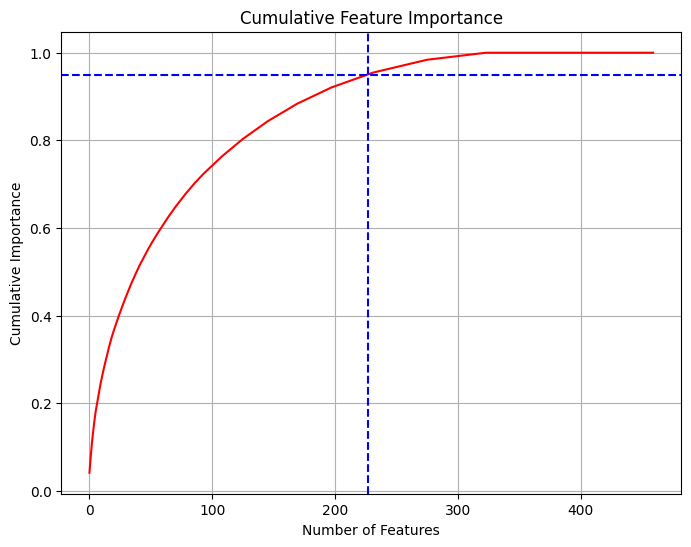

In [67]:
X_train_selected, importance_features = select_important_features(best_model, X_train, threshold=0.95)

In [68]:
# Compare the shape of the original and selected data
X_train.shape, X_train_selected.shape

((246008, 460), (246008, 227))

#### **Finding Insights**
We could reduce features from 460 to 227 features

In [69]:
# Select important features
X_test_selected = X_test[importance_features]

In [70]:
train_and_evaluate_model(best_model, X_train_selected, X_test_selected, y_train, y_test)

Model: LGBMClassifier
Accuracy Training dataset: 0.9217
ROC-AUC Training dataset: 0.8260
Accuracy Testing dataset: 0.9201
ROC-AUC Testing dataset: 0.7783
------------------------------


LGBMClassifier()

In [71]:
# Define the hyperparameter grid
param_grid = {
    'num_leaves': [15, 31],  # Lower values for smaller trees
    'max_depth': [-1,3, 6, 10],  # Limit tree depth
    'learning_rate': [0.01, 0.05],  # Slower learning
    'n_estimators': [50, 100, 200]  # Fewer trees
}


# Perform grid search with K-fold cross-validation
grid_search = perform_grid_search(X_train_selected, y_train, param_grid, cv=5, scoring='roc_auc')

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
Best roc_auc Score: 0.7775
Best Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
Best ROC-AUC Score: 0.7775


In [72]:
# Comparison to defaul model
train_and_evaluate_model(trained_models['LightGBM']['model'], X_train_selected, X_test_selected, y_train, y_test)
print(f"Hyperparameters: {trained_models['LightGBM']['params']}")

Model: LGBMClassifier
Accuracy Training dataset: 0.9217
ROC-AUC Training dataset: 0.8260
Accuracy Testing dataset: 0.9201
ROC-AUC Testing dataset: 0.7783
------------------------------
Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [73]:
# Evaluate the best model on the test set
final_model = grid_search.best_estimator_
train_and_evaluate_model(final_model, X_train_selected, X_test_selected, y_train, y_test)
print(f"Hyperparameters: {final_model.get_params()}")

Model: LGBMClassifier
Accuracy Training dataset: 0.9218
ROC-AUC Training dataset: 0.8265
Accuracy Testing dataset: 0.9201
ROC-AUC Testing dataset: 0.7801
------------------------------
Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


#### **Comparison of Default vs Fine-Tuned LGBM Model**

| Model               | Training Accuracy | Training ROC-AUC | Testing Accuracy | Testing ROC-AUC |
|---------------------|------------------|-----------------|------------------|-----------------|
| **Default LGBM**   | 0.9217           | 0.8260          | 0.9201           | 0.7783          |
| **Fine-Tuned LGBM** | 0.9218           | 0.8265          | 0.9201           | **0.7801**      |

### **Key Insights**
- The **Fine-Tuned LGBM model** slightly improves the **ROC-AUC on the test set (0.7801 vs. 0.7783)**, indicating better predictive power.
- The fine-tuned model **maintains similar accuracy** while improving generalization.
- **Hyperparameter tuning** involved reducing the **learning rate (0.1 → 0.05)**, increasing **estimators (100 → 200)**, and **setting max depth to 10**, which helped in fine-tuning the decision boundaries.
- **Feature selection with a threshold of 0.95** and **GridSearchCV** was applied to reduce overfitting.
- Despite the **marginal gain in performance**, the fine-tuned model is more optimized for unseen datasets.

In [74]:
# Fit the imputer on the selected features to export imputer
imputer.fit(X_train_selected)

SimpleImputer(strategy='median')

### **2.3 Model Explanability**

In [75]:
def plot_shap_dependence(shap_values, X_train_selected, selected_features, num_features=5):
    """
    Plots SHAP dependence plots for the top important features.

    Parameters:
    shape_values: SHAP values
    X_train_selected: The training data with selected features
    selected_features (list): List of selected feature names
    num_features (int): Number of top features to plot
    """

    # Convert Explanation object to NumPy array
    shap_values_array = shap_values.values if isinstance(shap_values, shap.Explanation) else shap_values

    # Compute feature importance based on SHAP values
    importance = np.abs(shap_values_array).mean(axis=0)  # Mean absolute SHAP value
    feature_importance = pd.DataFrame({'feature': selected_features, 'importance': importance})

    # Select top features from SHAP importance
    top_features = feature_importance.sort_values(by='importance', ascending=False).head(num_features)['feature']

    # Plot SHAP dependence plots
    for feature in top_features:
        shap.dependence_plot(feature, shap_values_array, X_train_selected[selected_features])

In [76]:
np.float = float  # Temporary fix for deprecated alias if numpy version is greater than 1.20.0

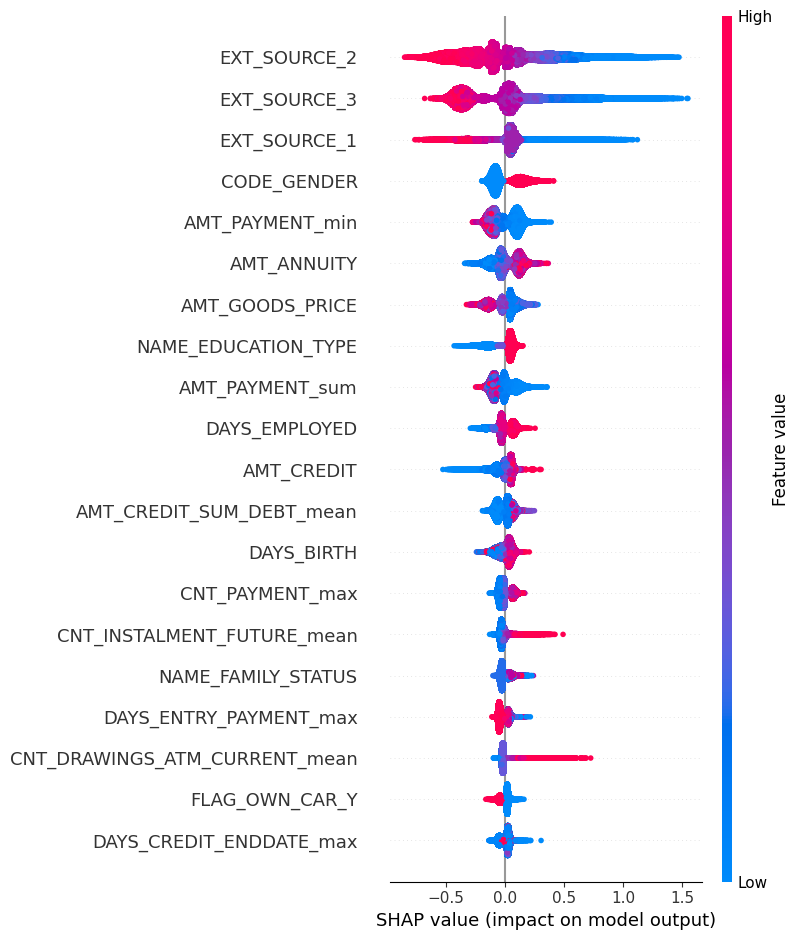

In [77]:
# Compute SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train_selected)[1]  # Select class 1
    
# Summary plot
shap.summary_plot(shap_values, X_train_selected)

### **Summary Finding**
- EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 are still the most important features impacting model predictions.
    Those higher values are associated with lower SHAP values.
- Code_Gender shows that gender (Male =1) is associated with lower SHAP values whereas gender (Female =0) is related with higher SHAP values
- AMT_PAYMENT_min is another important features impacting model predictions.
    this higher values are associated with lower SHAP values.

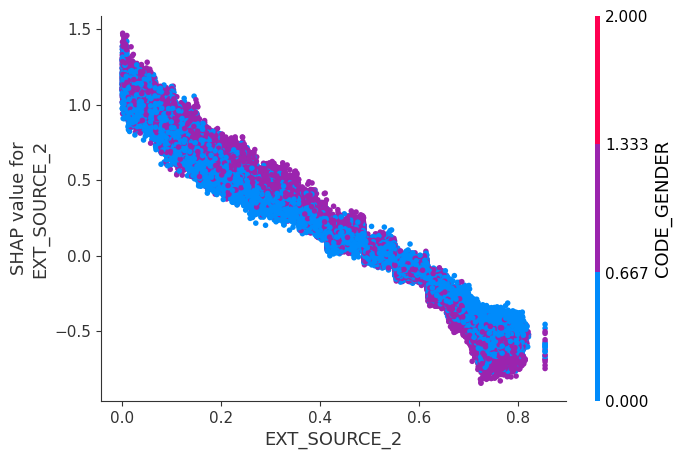

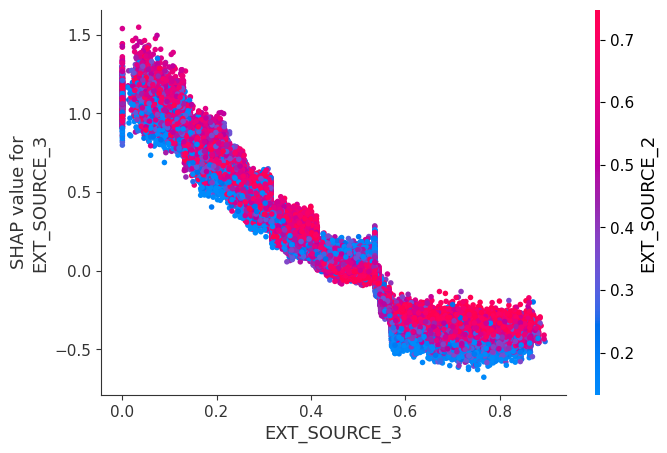

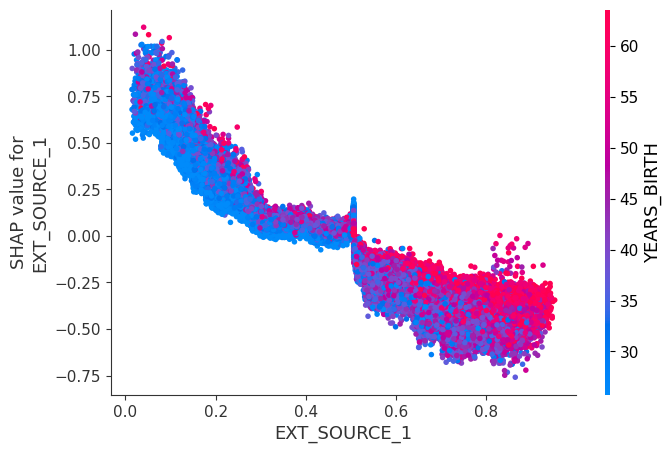

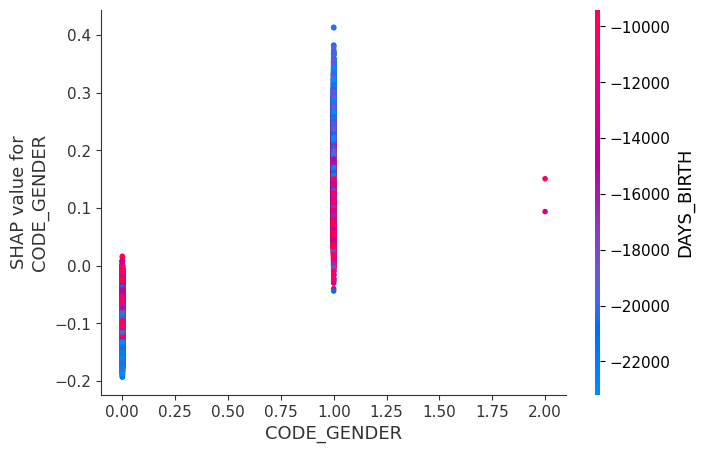

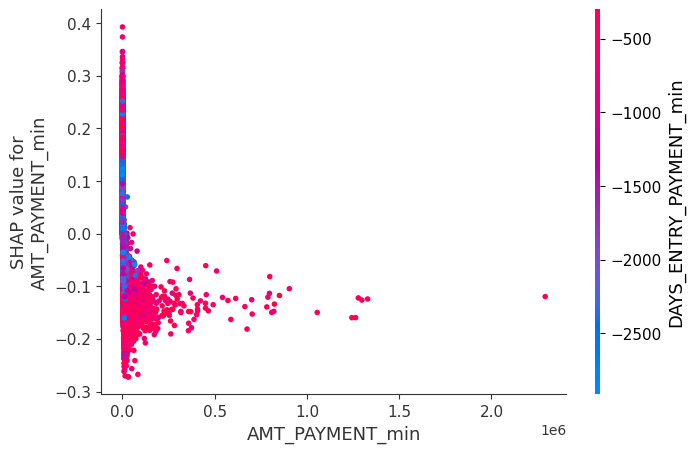

In [78]:
plot_shap_dependence(shap_values, X_train_selected, importance_features, num_features=5)

#### **Summary of SHAP Dependence Plot Findings for Top 5 Important Features**

The SHAP dependence plots provide insights into how the most important features influence the model’s predictions. Below is a refined summary:

| **Feature**         | **Description**                                  | **Impact on SHAP Values (Risk of Default)** |
|---------------------|--------------------------------------------------|---------------------------------------------|
| **EXT_SOURCE_2**    | Most important external risk source.             | **Higher values → Lower SHAP (Lower Risk)** <br> **Lower values → Higher SHAP (Higher Risk)** |
| **EXT_SOURCE_3**    | Second most important external risk source.      | **Higher values → Lower SHAP (Lower Risk)** <br> **Lower values → Higher SHAP (Higher Risk)** |
| **EXT_SOURCE_1**    | Third most important external risk source.       | **Higher values → Lower SHAP (Lower Risk)** <br> **Lower values → Higher SHAP (Higher Risk)** |
| **CODE_GENDER**     | Client’s gender.                                 | **Female gender category → Higher SHAP (Higher Risk)** <br> **Male gender category → Lower SHAP (Lower Risk)** |
| **AMT_PAYMENT_min** | Minimum payment amount made by the client.      | **Higher payments → Lower SHAP (Lower Risk)** <br> **Lower payments → Higher SHAP (Higher Risk)** |

#### **Key Insights**
- **External risk sources (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3)** show a **negative relationship** with default risk—higher values indicate lower risk.
- **Gender (CODE_GENDER)** plays a role in predicting loan default, with certain categories showing a higher risk with year age is lower whereas is less risk when they are older.
- **Minimum payment amount (AMT_PAYMENT_min)** has a strong effect—clients making **higher payments are less likely to default**.

### **2.4 Export Models and relevants datasets** 

In [79]:
# Assuming final_model and label_encoders are already defined
# Save the final model to a file
model_path  = '../models/'

# Save the final model to a file
with open(model_path+'final_model.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)
    
# Save the one-hot encoded columns to a file
with open(model_path+'one_hot_code_encoders.pkl', 'wb') as encoder_file:
    pickle.dump(one_hot_encoded_cols, encoder_file)

# Save the label encoders to a file
with open(model_path+'label_encoders.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoders, encoder_file)

# Save the imputer to a file
with open(model_path+'imputer.pkl', 'wb') as imputer_file:
    pickle.dump(imputer, imputer_file)
# Save the selected features to a file  
with open(model_path+'selected_features.pkl', 'wb') as selected_features_file:
    pickle.dump(importance_features, selected_features_file)

print("Model, encoders, selected_features, and imputer have been saved successfully.")

Model, encoders, selected_features, and imputer have been saved successfully.


In [80]:
# Create the processed folder if it doesn't exist
processed_folder = '../data/processed/'
os.makedirs(processed_folder, exist_ok=True)

# List of DataFrames to export
agg_dfs = {
    'bureau_agg': bureau_agg,
    'pre_appl_agg': pre_appl_agg,
    'pos_cash_agg': pos_cash_agg,
    'install_pay_agg': install_pay_agg,
    'credit_card_agg': credit_card_agg
}

# Export each DataFrame to a CSV file in the processed folder
for name, df in agg_dfs.items():
    df.to_csv(os.path.join(processed_folder, f'{name}.csv'), index=False)

print("All _agg DataFrames have been exported to the processed folder.")

All _agg DataFrames have been exported to the processed folder.
